In [1]:
import poppy
import jax

In [2]:
p = 3
n = 2
f = poppy.field(p,n)
f

field 9

In [3]:
a = poppy.random((2,2,2),f)
a

shape 2 2 2 over field 9

In [4]:
print(f'a.lift()\n{a.lift()}\n')
print(f'a.proj()\n{a.proj()}\n')
print(f'a.transpose().proj()\n{a.transpose().proj()}\n')
print(f'a.inv().proj()\n{a.inv().proj()}\n') 
print(f'(a@a.inv()).proj()\n{(a@a.inv()).proj()}\n')
print(f'a.trace().proj()\n{a.trace().proj()}\n')
print(f'a.det().proj()\n{a.det().proj()}\n')
print(f'a.rank()\n{a.rank()}\n')
print(f'a.ker().proj()\n{a.ker().proj()}\n')
print(f'a.im().proj()\n{a.im().proj()}\n')
print(f'a.mod(-a).proj()\n{a.mod(-a).proj()}\n')

a.lift()
[[[[[2 2]
    [2 1]]

   [[2 2]
    [2 1]]]


  [[[1 0]
    [0 1]]

   [[0 1]
    [1 1]]]]



 [[[[1 1]
    [1 2]]

   [[1 0]
    [0 1]]]


  [[[2 1]
    [1 0]]

   [[2 0]
    [0 2]]]]]

a.proj()
[[[8 8]
  [1 3]]

 [[4 1]
  [5 2]]]

a.transpose().proj()
[[[8 1]
  [8 3]]

 [[4 5]
  [1 2]]]

a.inv().proj()
[[[2 6]
  [5 3]]

 [[7 7]
  [4 3]]]

(a@a.inv()).proj()
[[[1 0]
  [0 1]]

 [[1 0]
  [0 1]]]

a.trace().proj()
[[[2 3]]]

a.det().proj()
[[[6 3]]]

a.rank()
[2 2]

a.ker().proj()
[[[0 0]
  [0 0]]

 [[0 0]
  [0 0]]]

a.im().proj()
[[[8 8]
  [1 3]]

 [[4 1]
  [5 2]]]

a.mod(-a).proj()
[[[0 0]
  [0 0]]

 [[0 0]
  [0 0]]]



In [5]:
a = poppy.random((1,32,32),f)
l,u,d,perm = a.lu()
print((poppy.block((l[0]@u[0]%p)[perm[0]],f)-a.lift()[0]).ravel())

[0 0 0 ... 0 0 0]


In [6]:
p = 2
n = 3
f = poppy.field(p,n)

print(f'GL2(F{p**n}) has order {len(poppy.gl2(f)[0])}')
print(f'PGL2(F{p**n}) has order {len(poppy.pgl2(f)[0])}')
print(f'SL2(F{p**n}) has order {len(poppy.sl2(f)[0])}')
print(f'PSL2(F{p**n}) has order {len(poppy.psl2(f)[0])}')

GL2(F8) has order 3528
PGL2(F8) has order 504
SL2(F8) has order 504
PSL2(F8) has order 504


In [7]:
p = 7

psl2c, i = poppy.psl2mod(p)

print(psl2c)
print(i)

[  92   93   94  119  120  121  122  161  162  163  164  232  233  234
  274  275  276  301  302  303  304  344  351  358  365  372  379  386
  393  401  409  442  451  462  471  491  504  514  527  540  555  570
  589  611  633  638  644  675  681  743  758  773  805  813  821  829
  842  847  864  869  897  906  926  941  947  953  987  997 1010 1023
 1088 1093 1115 1135 1148 1158 1171 1190 1198 1206 1214 1242 1248 1254
 1283 1298 1317 1330 1339 1359 1368 1374 1381 1388 1395 1402 1409 1416
 1423 1443 1452 1472 1487 1491 1506 1521 1527 1533 1564 1570 1578 1611
 1619 1632 1655 1668 1673 1690 1695 1718 1725 1732 1739 1746 1753 1760
 1767 1780 1793 1816 1822 1828 1834 1865 1876 1885 1905 1914 1919 1941
 1963 1996 2004 2012 2016 2031 2046 2131 2137 2143 2172 2177 2194 2199
 2215 2219 2234 2249 2263 2276 2299 2311 2320 2340 2359 2367 2375 2383]
[2401 2401 2401 ... 2401 2401 2401]


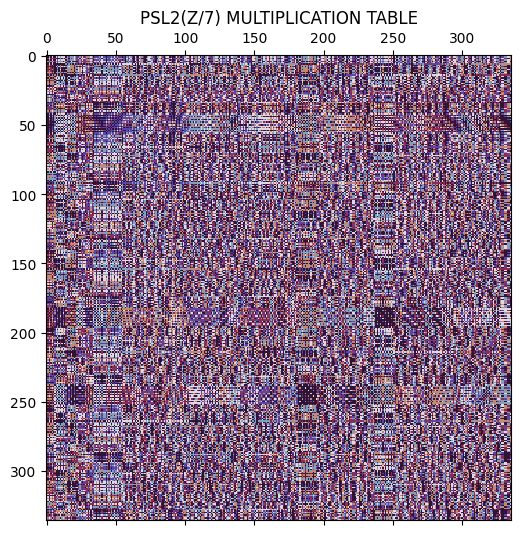

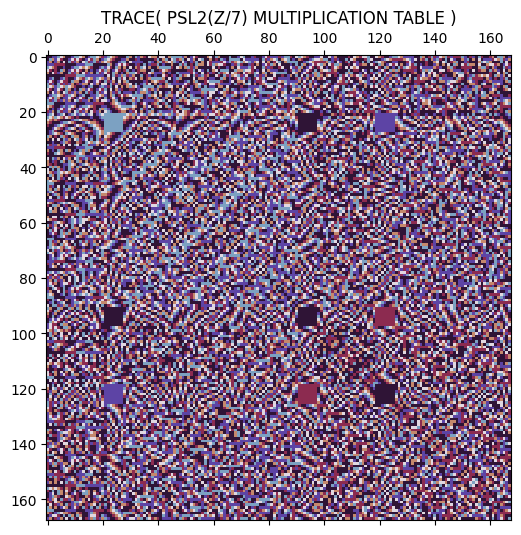

In [8]:
psl2 = jax.vmap(poppy.decode, in_axes = (0,None))(psl2c,p).squeeze()

poppy.plot(jax.numpy.tensordot(psl2,psl2, axes=([2],[1])).reshape((len(psl2)*2,-1))%p, title = f'PSL2(Z/{p}) MULTIPLICATION TABLE')
poppy.plot(poppy.tracemod(jax.numpy.tensordot(psl2,psl2, axes=([2],[1])).swapaxes(1,2)%p,p), title = f'TRACE( PSL2(Z/{p}) MULTIPLICATION TABLE )')

In [9]:
p = 7

pgl2c, i = poppy.pgl2mod(p)

print(pgl2c)
print(i)

[  56   57   64   71   78   85   92  105  106  113  120  127  134  141
  154  155  162  169  176  183  190  203  204  211  218  225  232  239
  252  253  260  267  274  281  288  301  302  309  316  323  330  337
  344  351  358  365  372  379  386  393  399  407  414  421  428  435
  442  448  449  456  463  477  484  491  497  498  505  512  519  533
  540  546  547  561  568  575  582  589  595  596  603  617  624  631
  638  644  645  652  659  666  673  687  694  701  708  715  722  729
  736  742  743  757  764  771  778  785  791  799  806  813  820  827
  834  840  841  848  862  869  876  883  889  890  897  904  918  925
  932  938  939  946  953  960  967  981  987  988  995 1002 1009 1023
 1030 1037 1044 1051 1058 1065 1072 1079 1085 1086 1093 1107 1114 1121
 1128 1134 1135 1142 1149 1156 1170 1177 1183 1191 1198 1205 1212 1219
 1226 1232 1233 1240 1247 1254 1261 1275 1281 1282 1296 1303 1310 1317
 1324 1330 1331 1338 1345 1359 1366 1373 1380 1387 1394 1401 1408 1415
 1422 

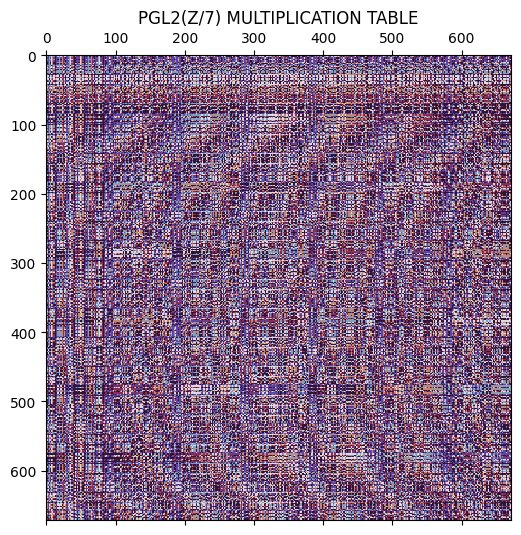

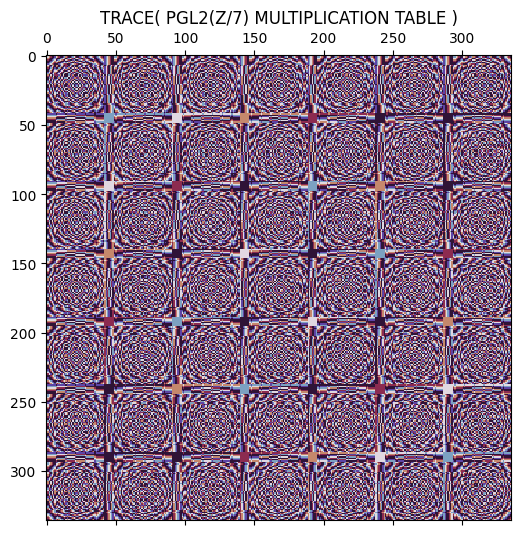

In [10]:
pgl2 = jax.vmap(poppy.decode, in_axes = (0,None))(pgl2c,p).squeeze()

poppy.plot(jax.numpy.tensordot(pgl2,pgl2, axes=([2],[1])).reshape((len(pgl2)*2,-1))%p, title = f'PGL2(Z/{p}) MULTIPLICATION TABLE')
poppy.plot(poppy.tracemod(jax.numpy.tensordot(pgl2,pgl2, axes=([2],[1])).swapaxes(1,2)%p,p), title = f'TRACE( PGL2(Z/{p}) MULTIPLICATION TABLE )')

In [11]:
p = 23
q = 17

lps, i = poppy.lps(p,q)

print(lps)
print(i)

[[65111 65383 60249 ... 61779 67831 67559]
 [32777 28901 81856 ... 41226 36466  8994]
 [28051 71146 13567 ... 75804 10524 38217]
 ...
 [82332  4200 72336 ... 50355 30278 81193]
 [41209  4557 36381 ... 54588 36976 58328]
 [55438  2279 79884 ... 79510 28493 50576]]
[83521 83521 83521 ... 83521 83521 83521]
